In [14]:
print(const.AGEO_LENGTH_IN_CM)

147684.983


In [19]:
from tovlib import *
#solve_ivp: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp 



In [20]:


class tov_h():

    def __init__(self, peos, eos_file, central_enth_arr, N_pts,h_end):
        self.physical_eos = peos
        self.eos_file = eos_file
        self.central_enth_arr = central_enth_arr
        self.N_pts = N_pts
        self.h_end = h_end

    def eos_from_h(self,h_in):
        
        ds=np.loadtxt(self.eos_file,comments='#',skiprows=5)
        #print(self.eos_file, len(ds)) 
        rho, edens, pres, gamma, enth = (ds[:,1],ds[:,2],ds[:,3],ds[:,4],ds[:,5])
        ## returning values in units G=c=M_sun=1 
        rho_out   = splev(h_in,splrep(enth,rho,k=3,s=0)) #* (const.CGS_G*const.AGEO_LENGTH_IN_CM**2/const.CGS_C**2)
        edens_out = splev(h_in,splrep(enth,edens,k=3,s=0)) * (const.CGS_G*const.AGEO_LENGTH_IN_CM/const.CGS_C**4) 
        gamma_out = splev(h_in,splrep(enth,gamma,k=3,s=0))
        pres_out  = splev(h_in,splrep(enth,pres,k=3,s=0)) * (const.CGS_G*const.AGEO_LENGTH_IN_CM/const.CGS_C**4)
        
        return edens_out, gamma_out, pres_out, rho_out
        
    def calc_tidal_deformability(self, C, Y,m):
        # """ Compute the dimensionless tidal deformability parameter Lambda from the compactness C and 
        # the Lindblom y-potential at the surface of a polytropic star"""

        # Eq.(C1,C2) of Lindblom & Indik 2014
        zeta = 4. * C**3 * (13. - 11.*Y + C*(3.*Y-2.) + 2.*(C**2)*(1.+Y)) + 3. * ((1.-2.*C)**2) * (2. - Y + 2.*C*(Y-1.)) *np.log(1.-2.*C) + 2. * C * (6. - 3.*Y + 3.*C*(5.*Y-8.))
        Lambda_dimensionless = (16./(15.*zeta)) * ((1.-2.*C)**2) * (2. + 2.*C*(Y-1.) - Y)  #dimensionless tidal deformability
        lambda_dimensional =   Lambda_dimensionless/const.CGS_G *(const.CGS_G*m*const.CGS_MSUN/const.CGS_C**2)**5
        return lambda_dimensional

    def tov(self, var,h):
        
        r, m, m_baryon, yp = var
        
        #if eos_file != None:
        #eden = self.physical_eos.edens_inv( P )
        #rho = self.physical_eos.rho( P )
        #eos_gamma = self.physical_eos.gamma_inv(P)
        
        #print(h)
        edens, eos_gamma, P, rho = self.eos_from_h(h)
        #print(edens, eos_gamma, P)
        
        #dPdh =  edens + P         
        #dPdr =  -(edens + P)*(m + 4.0*np.pi*r**3*P)
        #drdh =  dPdh/dPdr    #/(r*(r - 2.0*const.CGS_G*m/const.CGS_C**2))
        
        
        drdh = - r*(r-2*m)/(m+4*np.pi*r**3*P)
        dmdh = -4*np.pi*r**3*(r-2*m)/(m+4*np.pi*r**3*P)                  #drdh * 4.0*np.pi*r**2*edens
        dm_baryondh =   dmdh*(1-2*m/r)**(-0.5)

        #rho=eden*const.CGS_C**2
        dypdr = -yp**2/r -(r + 4*np.pi*r**3*(P-edens))*yp/(r*(r-2*m)) + (4*(m+4*np.pi*r**3*P)**2)/(r*(r-2*m)**2) + 6/(r-2*m) - 4*np.pi*(r**2)*(5*edens+9*P+(edens+P)**2/(P*eos_gamma))/(r-2*m)
        dypdh = dypdr * drdh
        
        return [drdh, dmdh, dm_baryondh,dypdh]

    def tovsolve(self, enth_c):
        
        N = self.N_pts
        h = np.linspace(enth_c,self.h_end,N)
        #print(h)
        #r = np.linspace(1.e0, 1.8e6, N)
        #r = np.logspace(0.0,6.3,N)
        #P = self.physical_eos.pressure( rhoc )
        #eden = self.physical_eos.edens_inv( P )
        #rho = self.physical_eos.rho( P )
        
        edens, gamma, pres, rho = self.eos_from_h(enth_c)
        #print(edens, gamma, pres, rho)
        #p = pres
        ###### Following Lindblom and IndiK ###
        #edens, gamma, pres, rho = self.eos_from_h(h[1])

        h_eps=h[0]-h[1]
        print(h_eps)
        
        
        """r1=np.sqrt(3./(2*np.pi*(edens+3*pres)))
        r3 = -(r1/(4*(edens+3*pres)))*(edens-3*pres-3*(edens+pres)**2/(5*pres*gamma))
        #print('r3',r3)
        r = r1*np.sqrt(h_eps) + r3*h_eps**1.5
        #print(r1*np.sqrt(h_eps),r3*h_eps**1.5)
        m3 = 4./3.*np.pi*r1**3*edens
        m5 = 4*np.pi*r1**3*(r3*edens/r1 - (edens+pres)**2/(5*pres*gamma))
        m = m3*h_eps**1.5 + m5*h_eps**2.5          #4*np.pi*r**3*edens                     #4.0*np.pi*r[0]**3*edens
        m_baryon = m*(1-2*m/r)**(-0.5)       #needs correct power series expression; perhaps ok for now     #4.0*np.pi*r[0]**3*rho*(1-2*const.CGS_G*m/(r[0]*const.CGS_C**2))**(-0.5)
        
        y2 = -(6/(7*(edens+3*pres))) * (edens/3 + 11*pres + (edens+pres)**2./(pres*gamma))
        yp=2.+y2*h_eps"""
        
        
        ### Naive initial consitions ####
        eps = 1.e-5
        r = eps
        m = 4*np.pi*r**3*edens
        m_baryon = m*(1-2*m/r)**(-0.5)
        yp = 2.
        
        print(r, m, m_baryon, yp)
        
        psol = odeint(self.tov, [r, m, m_baryon, yp], h, rtol=1.0e-4, atol=1.0e-4)
        #psol = solve_ivp(self.tov, [1.e0,5.8e6] ,[P, m, m_baryon, yp], method='RK45',t_eval=r )
        #print m, m_baryon, rhoc
        return psol[:,0], psol[:,1], psol[:,2], psol[:,3]
        #return psol.t, psol.y[0], psol.y[1], psol.y[2], psol.y[3] 

    def mass_radius(self):
        N = 10
        mcurve = np.zeros(N)
        rcurve = np.zeros(N)
        mbcurve = np.zeros(N)
        ypcurve = np.zeros(N)
        #rhocs = np.logspace(12.5, 20.0, N)
        
        #central_enth_arr = self.central_enth_arr #np.linspace(0.01,0.25,N)

        mass_max = 0.0
        j = 0
        for enth_c in self.central_enth_arr: #central_enth_arr:
            print(f'for central enthalpy = {enth_c}')
            rad, mass, mass_baryon, yp_lambda = self.tovsolve(enth_c)

            #rad  /= 1.0e5 #cm to km
            #mass /= const.CGS_MSUN
            #mass_baryon /= const.CGS_MSUN
            
            #print self.peos
            #print(rad)
            #print "Central Density=%f, Gravitational Mass=%f, Baryonic Mass=%f, Radius=%f"%(rhoc,mass.max(),mass_baryon.max(),rad.max())

            
            mstar = mass[-1]
            rstar = rad[-1]
            ypstar = yp_lambda[-1]
            mbaryonStar = mass_baryon[-1]
            
            """for i, p in enumerate(press):
                if p > 0.0:
                    mstar = mass[i]
                    rstar = rad[i]
                    mbaryonStar = mass_baryon[i]
                    ypstar = yp_lambda[i]"""
                    
            mcurve[j] = mstar
            rcurve[j] = rstar
            mbcurve[j] = mbaryonStar
            
            C=(const.CGS_G/const.CGS_C**2)*(mstar*const.CGS_MSUN)/(rstar*1.e5)
            ypcurve[j] = ypstar
            ypcurve[j] = self.calc_tidal_deformability(C,ypstar,mstar) 
    
            print(mstar,rstar)


            j += 1
            if mass_max < mstar:
                mass_max = mstar
            else:
                break

        return mcurve[:j], rcurve[:j], central_enth_arr[:j], mbcurve[:j], ypcurve[:j]


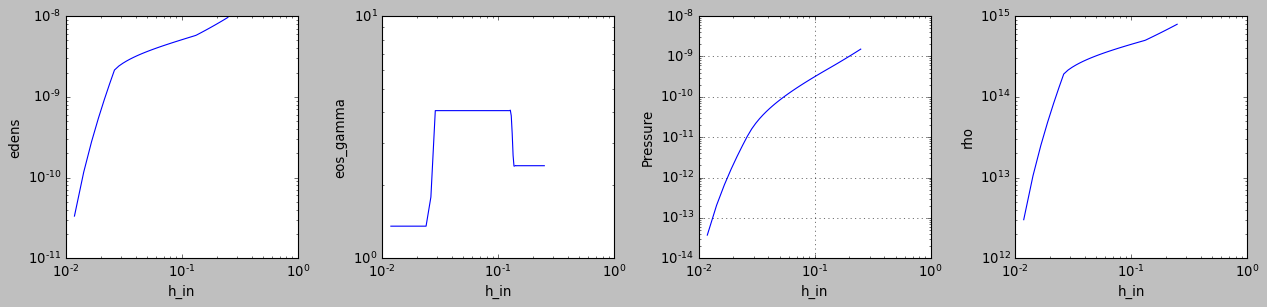

In [22]:
#key='BLH'; eosfile='./eos_tables/BLH_data.out'
key = 'ALF2'; eosfile='./eos_tables/ALF2_data.out'
#dense_eos = get_eos(key,eosfile)
#eos = glue_crust_and_core( SLyCrust, dense_eos )
N=1000
central_h_low=0.02; central_h_high = 0.25
central_enth_arr = np.linspace(central_h_low,central_h_high,N)
N_pts = 1000
h_end=0.0119
BLH=tov_h(peos=key,eos_file=eosfile,central_enth_arr=central_enth_arr,N_pts=N_pts,h_end=h_end)

h_in = np.linspace(h_end,central_h_high,100)
#print(h_in)
edens, eos_gamma, P, rho = BLH.eos_from_h(h_in)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(16,4))

ax1.plot(h_in,edens)
#ax1.set_xlim([9.e11,1.e16]); 
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set(xlabel='h_in',ylabel='edens')

ax2.plot(h_in,eos_gamma)
ax2.set(xlabel='h_in',ylabel='eos_gamma')
#ax2.set_xlim([9.e11,1.e16]) 
ax2.set_xscale('log'); ax2.set_yscale('log')

ax3.plot(h_in,P)
ax3.set(xlabel='h_in',ylabel='Pressure')
ax3.grid(True)
#ax3.set_xlim([9.e11,1.e16]);ax3.set_ylim([0,1])
ax3.set_xscale('log'); ax3.set_yscale('log')

ax4.plot(h_in, rho)
ax4.set_xscale('log'); ax4.set_yscale('log')
ax4.set(xlabel='h_in',ylabel='rho')
    
#plt.loglog(edens,h_in)
#plt.show()

plt.tight_layout()
plt.show()



0.0004885885885885788
1e-05 2.761896146824642e-22 2.761896146824642e-22 2.0


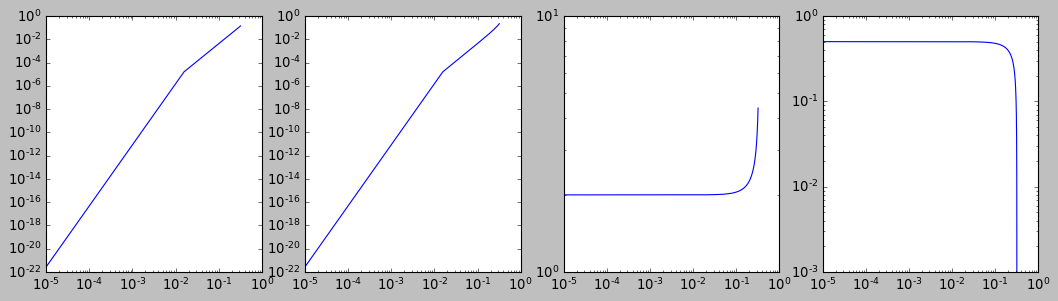

0.4474737812859623
0.1370358472731178


In [23]:
enth_c = 0.5
rad, mass, mass_baryon, yp_lambda = BLH.tovsolve(enth_c)

h_arr = np.linspace(enth_c,1.e-3,N_pts)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(16,4))
ax1.loglog(rad,mass)
ax2.loglog(rad,mass_baryon)
ax3.loglog(rad,yp_lambda)
ax4.loglog(rad,h_arr)
plt.show()

print(rad[-1]*1.4)
print(mass[-1])

In [47]:
print(rad[-1]*const.AGEO_LENGTH_IN_CM/1.e5)
print(mass[-1],(mass[-1]*const.AGEO_LENGTH_IN_CM)*const.CGS_C**2/const.CGS_G/const.CGS_MSUN)

0.473862273425462
0.13862426932957087 0.13864515810302486


In [14]:



#mass,radius,rhoc,mb,yp = BLH.mass_radius()
plt.plot(radius*const.AGEO_LENGTH_IN_CM/1.e5,(mass*const.AGEO_LENGTH_IN_CM)*const.CGS_C**2/const.CGS_G/const.CGS_MSUN,'r.')
plt.show()

NameError: name 'radius' is not defined

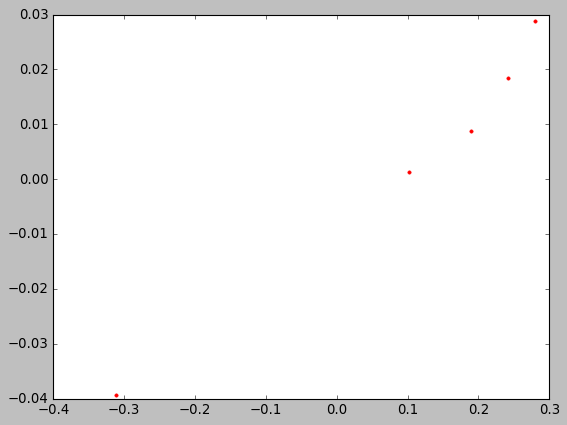

In [59]:

plt.plot(radius*const.AGEO_LENGTH_IN_CM/1.e5,mass*(const.AGEO_LENGTH_IN_CM*const.CGS_C**2/const.CGS_G/const.CGS_MSUN),'r.')
plt.show()

In [19]:
print(2.5*np.log((1.0e2*const.CGS_C**2+2.4e19)/(1.0e2*const.CGS_C**2)))

0.0006675009142067027


7.77786843390644e-06


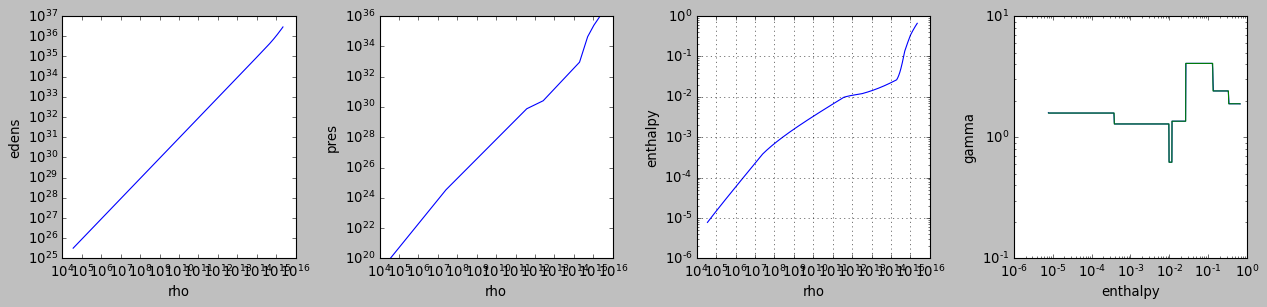

In [15]:
fm=1.e-13 #1femotometer in cm
dens_conversion=const.CGS_AMU/(fm**3)
edens_conversion=const.CGS_C**2

key='ALF2'
dense_eos = get_eos(key)
eos = glue_crust_and_core( SLyCrust, dense_eos )
pres_arr = np.logspace(20,36,1000)
edens_arr = np.array([eos.edens_inv(p) for p in pres_arr] )* const.CGS_C**2
rho_arr = [eos.rho(p) for p in pres_arr]
gamma = [eos.gamma_inv(p) for p in pres_arr]


dp_dedens_arr=np.gradient(pres_arr,edens_arr) #https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
gamma_arr=((edens_arr+pres_arr)/pres_arr) * dp_dedens_arr 
enth_arr=[]
enth_arr.append(2.5*np.log((edens_arr[0]+pres_arr[0])/edens_arr[0]))
print(2.5*np.log((edens_arr[0]+pres_arr[0])/edens_arr[0]))
for i,(rho,edens,pres) in enumerate(zip(rho_arr,edens_arr,pres_arr)):
    if i > 0:
        c = np.log(pres/pres_arr[i-1])/np.log(edens/edens_arr[i-1])
        enth_arr.append(enth_arr[i-1]+(c/(c-1))*np.log(edens_arr[i-1]/edens*(edens+pres)/(edens_arr[i-1]+pres_arr[i-1])))
        #print(enth_arr[i-1])

        
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(16,4))

#print(enth_arr)
ax1.plot(rho_arr,edens_arr)
#ax1.set_xlim([9.e11,1.e16]); 
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set(xlabel='rho',ylabel='edens')
ax2.plot(rho_arr,pres_arr)
ax2.set(xlabel='rho',ylabel='pres')
#ax2.set_xlim([9.e11,1.e16]) 
ax2.set_xscale('log'); ax2.set_yscale('log')
ax3.plot(rho_arr,enth_arr)
ax3.set(xlabel='rho',ylabel='enthalpy')
ax3.grid(True)
#ax3.set_xlim([9.e11,1.e16]);ax3.set_ylim([0,1])
ax3.set_xscale('log'); ax3.set_yscale('log')

ax4.plot(enth_arr,gamma_arr)
ax4.plot(enth_arr,gamma)
ax4.set_xscale('log'); ax4.set_yscale('log')
ax4.set(xlabel='enthalpy',ylabel='gamma')



#splrep(edens,enth,k=3,s=0)
    
plt.tight_layout()
plt.show()


index=np.array([int(i) for i in range(len(rho_arr))])   #  
np.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_arr, edens_arr, pres_arr, gamma_arr, enth_arr],header='\n#i rho edens pres gamma enthalpy',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')

np.savetxt(f'./eos_tables/{key}_table.out',np.c_[index, np.array(rho_arr)/dens_conversion, np.array(edens_arr)/edens_conversion, pres_arr],header='\n#i rho edens pres',comments=f'#density, energy density and pressure in cgs units for eos={key}.\n')



6.379686072269269e-06
0.0006689770240705531
8.212708095846884e-06


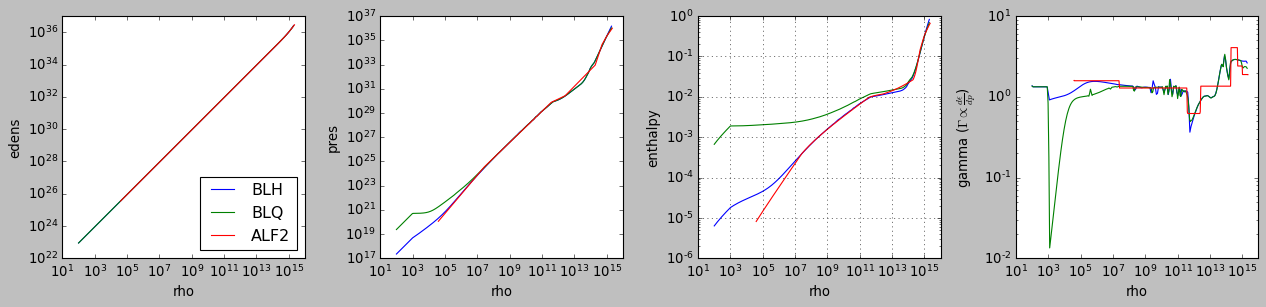

In [67]:

fm=1.e-13 #1femotometer in cm
dens_conversion=const.CGS_AMU/(fm**3)
edens_conversion=const.CGS_C**2


"""
key='BLH'
blh=np.loadtxt('./eos_tables/BLH_new_14-Apr-2020.lorene',comments='#')
rho_arr, edens_arr, p_arr = (blh[:,1],blh[:,2],blh[:,3])

enth_arr=[]
enth_arr.append(2.5*np.log((edens_arr[0]+p_arr[0])/edens_arr[0]))

for i,(rho,edens,p) in enumerate(zip(rho_arr,edens_arr,p_arr)):
    if i > 0:
        c = np.log(p/p_arr[i-1])/np.log(edens/edens_arr[i-1])
        enth_arr.append(enth[i-1]+(c/(c-1))*np.log(edens_arr[i-1]/edens*(edens+p)/(edens_arr[i-1]+p_arr[i-1])))
        
print(enth_arr,len(enth_arr))
index=np.array([int(i) for i in range(len(rho_arr))])
np.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_arr/dens_conversion, edens_arr/edens_conversion, p_arr, gamma_new, enth_arr],header='\n#i rho edens pres gamma',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')
"""

keys=['BLH','BLQ','ALF2'] #,'ALF2_matlab']
files=['./eos_tables/BLH_new_14-Apr-2020.lorene','./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene','./eos_tables/ALF2_table.out',]
    
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(16,4))

for key,file in zip(keys,files):
    eos=np.loadtxt(file,comments='#',skiprows=8)
    rho_arr, edens_arr, pres_arr = (eos[:,1],eos[:,2],eos[:,3])
    rho_arr = rho_arr*dens_conversion
    edens_arr = edens_arr*edens_conversion
    
    dp_dedens_arr=np.gradient(pres_arr,edens_arr) #https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
    gamma_arr=((edens_arr+pres_arr)/pres_arr) * dp_dedens_arr 
    enth_arr=[]
    enth_arr.append(2.5*np.log((edens_arr[0]+pres_arr[0])/edens_arr[0]))
    print(2.5*np.log((edens_arr[0]+pres_arr[0])/edens_arr[0]))
    for i,(rho,edens,pres) in enumerate(zip(rho_arr,edens_arr,pres_arr)):
        if i > 0:
            c = np.log(pres/pres_arr[i-1])/np.log(edens/edens_arr[i-1])
            enth_arr.append(enth_arr[i-1]+(c/(c-1))*np.log(edens_arr[i-1]/edens*(edens+pres)/(edens_arr[i-1]+pres_arr[i-1])))
            #print(enth_arr[i-1])
    #print(enth_arr,len(enth_arr))

    #p_new=np.logspace(14,36,500)
    #key='BLQ'
    #rho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene') #returns in cgs


    index=np.array([int(i) for i in range(len(rho_arr))])   #rho_arr/dens_conversion, edens_arr/edens_conversion  
    np.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_arr, edens_arr, pres_arr, gamma_arr, enth_arr],header='\n#i rho edens pres gamma enthalpy',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')

    #print(enth_arr)
    ax1.plot(rho_arr,edens_arr,label=key)
    #ax1.set_xlim([9.e11,1.e16]); 
    ax1.set_xscale('log'); ax1.set_yscale('log')
    ax1.set(xlabel='rho',ylabel='edens')
    ax1.legend(loc=4)
    
    ax2.plot(rho_arr,pres_arr)
    ax2.set(xlabel='rho',ylabel='pres')
    #ax2.set_xlim([9.e11,1.e16]) 
    ax2.set_xscale('log'); ax2.set_yscale('log')
    ax3.plot(rho_arr,enth_arr)
    ax3.set(xlabel='rho',ylabel='enthalpy')
    ax3.grid(True)
    #ax3.set_xlim([9.e11,1.e16]);ax3.set_ylim([0,1])
    ax3.set_xscale('log'); ax3.set_yscale('log')
    
    ax4.plot(rho_arr,gamma_arr,label=r'$\Gamma\propto\frac{d\epsilon}{dp}$')
    ax4.set_xscale('log'); ax4.set_yscale('log')
    ax4.set(xlabel='rho',ylabel=r'gamma')
    
    
    
    #splrep(edens,enth,k=3,s=0)
    
plt.tight_layout()
plt.show()


    
    

In [76]:
eosfile='./eos_tables/BLH_data.out'
ds=np.loadtxt(eosfile,comments='#',skiprows=5)
print(eosfile, len(ds))
rho, edens, pres, gamma, enth = (ds[:,1],ds[:,2],ds[:,3],ds[:,4],ds[:,5])
print(gamma,len(gamma))
h_in=120
#rho_out   = splev(h_in,splrep(enth,rho,k=3,s=0)) 
edens_out = splev(h_in,splrep(enth,edens,k=3,s=0)) 
gamma_out = splev(h_in,splrep(enth,gamma,k=3,s=0))
pres_out  = splev(h_in,splrep(enth,pres,k=3,s=0))
print(edens_out, gamma_out, pres_out)

./eos_tables/BLH_data.out 199
[1.33216699 1.33216699 1.33216699 1.33216699 1.33216699 1.33216698
 1.33216698 1.33216698 1.33216698 1.33216698 1.33216698 1.33216698
 1.33216698 1.32178838 1.1079997  0.91635925 0.9276157  0.93778059
 0.94703038 0.95553663 0.96346875 0.97099307 0.9782737  0.98547363
 0.99275602 1.00028548 1.00822906 1.01675604 1.02603947 1.03625102
 1.04756635 1.06015606 1.07418151 1.08979487 1.10711658 1.12623572
 1.14720052 1.16999654 1.19454719 1.22069801 1.24820207 1.27673463
 1.30589506 1.33521738 1.36419446 1.39230482 1.41901581 1.44390852
 1.46662025 1.48684444 1.50439946 1.51919481 1.53126235 1.54070723
 1.54768579 1.55240047 1.55509103 1.55596492 1.55525055 1.55318275
 1.54994736 1.54569266 1.54061229 1.53482969 1.52845343 1.52161938
 1.51441862 1.50694513 1.49931102 1.49139858 1.48404273 1.4738808
 1.46619432 1.46050436 1.45290544 1.44553989 1.4383963  1.4269992
 1.41876803 1.41763514 1.41363561 1.4074329  1.40201463 1.39660709
 1.39153446 1.38660452 1.38210561 

In [69]:


class tov():

    def __init__(self, peos,int_pts,rad_low,rad_high,central_rho_arr,eos_file=None):
        self.physical_eos = peos
        self.eos_file = eos_file
        self.int_pts = int_pts
        self.rad_low = rad_low
        self.rad_high = rad_high
        self.rhocs = central_rho_arr

    def calc_tidal_deformability(self, C, Y,m):
        # """ Compute the dimensionless tidal deformability parameter Lambda from the compactness C and 
        # the Lindblom y-potential at the surface of a polytropic star"""

        # Eq.(C1,C2) of Lindblom & Indik 2014
        zeta = 4. * C**3 * (13. - 11.*Y + C*(3.*Y-2.) + 2.*(C**2)*(1.+Y)) + 3. * ((1.-2.*C)**2) * (2. - Y + 2.*C*(Y-1.)) *np.log(1.-2.*C) + 2. * C * (6. - 3.*Y + 3.*C*(5.*Y-8.))
        Lambda_dimensionless = (16./(15.*zeta)) * ((1.-2.*C)**2) * (2. + 2.*C*(Y-1.) - Y)  #dimensionless tidal deformability
        lambda_dimensional =   Lambda_dimensionless/const.CGS_G *(const.CGS_G*m*const.CGS_MSUN/const.CGS_C**2)**5
        return lambda_dimensional

    def tov(self, y,r):
        
        P, m, m_baryon, yp = y
        
        #if eos_file != None:
        eden = self.physical_eos.edens_inv( P )
        rho = self.physical_eos.rho( P )
        eos_gamma = self.physical_eos.gamma_inv(P)
        
        G=const.CGS_G; c=const.CGS_C 

        dPdr = -G*(eden + P/c**2)*(m + 4.0*np.pi*r**3*P/c**2)
        dPdr = dPdr/(r*(r - 2.0*G*m/c**2))
        dmdr = 4.0*np.pi*r**2*eden
        dm_baryondr = 4.0*np.pi*r**2*eden*(1-2*G*m/(r*c**2))**(-0.5)
        #G=cgs.G; c=cgs.c
        
        rho=eden*const.CGS_C**2
        dypdr= -yp**2/r -(r + (G/c**4)*4*np.pi*r**3*(P-rho))*yp/(r*(r-2*G*m/c**2)) + (G**2/c**4)*(4*(m+4*np.pi*r**3*P/c**2)**2)/(r*(r-2*G*m/c**2)**2) + 6/(r-2*const.CGS_G*m/const.CGS_C**2) - 4*np.pi*(r**2)*(5*rho+9*P+(rho+P)**2/(P*eos_gamma))*G/(c**4 * (r-2*G*m/c**2))

        return [dPdr, dmdr, dm_baryondr,dypdr]

    def tovsolve(self, rhoc):
        
        r = np.linspace(self.rad_low, self.rad_high, self.int_pts)
        #r = np.logspace(-4,6.3,N)
        P = self.physical_eos.pressure( rhoc )
        eden = self.physical_eos.edens_inv( P )
        rho = self.physical_eos.rho( P )
        
        m = 4.0*np.pi*r[0]**3*eden
        m_baryon = 4.0*np.pi*r[0]**3*eden*(1-2*const.CGS_G*m/(r[0]*const.CGS_C**2))**(-0.5)
        yp=2.
        psol = odeint(self.tov, [P, m, m_baryon, yp], r, rtol=1.0e-6, atol=1.0e-4)
        #psol = solve_ivp(self.tov, [1.e0,5.8e6] ,[P, m, m_baryon, yp], method='RK45',t_eval=r )
        #print m, m_baryon, rhoc
        return r, psol[:,0], psol[:,1], psol[:,2], psol[:,3]
        #return psol.t, psol.y[0], psol.y[1], psol.y[2], psol.y[3] 

    def mass_radius(self):
        #N = 300
        mcurve = np.zeros(N)
        rcurve = np.zeros(N)
        mbcurve = np.zeros(N)
        ypcurve = np.zeros(N)
        rhocs = self.rhocs  #

        mass_max = 0.0
        j = 0
        for rhoc in rhocs:
            rad, press, mass, mass_baryon, yp_lambda = self.tovsolve(rhoc)

            rad  /= 1.0e5 #cm to km
            mass /= const.CGS_MSUN
            mass_baryon /= const.CGS_MSUN
            #print self.peos
            #print rad
            #print "Central Density=%f, Gravitational Mass=%f, Baryonic Mass=%f, Radius=%f"%(rhoc,mass.max(),mass_baryon.max(),rad.max())

            mstar = mass[-1]
            rstar = rad[-1]
            ypstar = yp_lambda[-1]
            for i, p in enumerate(press):
                if p > 0.0:
                    mstar = mass[i]
                    rstar = rad[i]
                    mbaryonStar = mass_baryon[i]
                    ypstar = yp_lambda[i]
            mcurve[j] = mstar
            rcurve[j] = rstar
            mbcurve[j] = mbaryonStar
            
            C=(const.CGS_G/const.CGS_C**2)*(mstar*const.CGS_MSUN)/(rstar*1.e5)
            ypcurve[j] = ypstar
            ypcurve[j] = self.calc_tidal_deformability(C,ypstar,mstar) 
    


            j += 1
            if mass_max < mstar:
                mass_max = mstar
            else:
                break

        return mcurve[:j], rcurve[:j], rhocs[:j], mbcurve[:j], ypcurve[:j]


In [71]:
key='ALF2'
dense_eos = get_eos(key)
eos = glue_crust_and_core( SLyCrust, dense_eos )

rho_arr = np.logspace(12,15,100)
pres_arr = [eos.pressure(rho) for rho in rho_arr]
eden_arr = [eos.edens_inv(rho) for rho in rho_arr]
gamma_arr = [eos.gamma_inv(rho) for rho in rho_arr]


rhoc=1.e13
Pc=eos.pressure(rhoc)
P_in = np.logspace(24,np.log10(Pc),100)
#print(h_in)
eden = eos.edens_inv( P )
rho = eos.rho( P )

edens, eos_gamma, P, rho = BLH.eos_from_h(h_in)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(16,4))

ax1.plot(h_in,edens)
#ax1.set_xlim([9.e11,1.e16]); 
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set(xlabel='h_in',ylabel='edens')

ax2.plot(h_in,eos_gamma)
ax2.set(xlabel='h_in',ylabel='eos_gamma')
#ax2.set_xlim([9.e11,1.e16]) 
ax2.set_xscale('log'); ax2.set_yscale('log')

ax3.plot(h_in,P)
ax3.set(xlabel='h_in',ylabel='Pressure')
ax3.grid(True)
#ax3.set_xlim([9.e11,1.e16]);ax3.set_ylim([0,1])
ax3.set_xscale('log'); ax3.set_yscale('log')

ax4.plot(h_in, rho)
ax4.set_xscale('log'); ax4.set_yscale('log')
ax4.set(xlabel='h_in',ylabel='rho')
    
#plt.loglog(edens,h_in)
#plt.show()

plt.tight_layout()
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

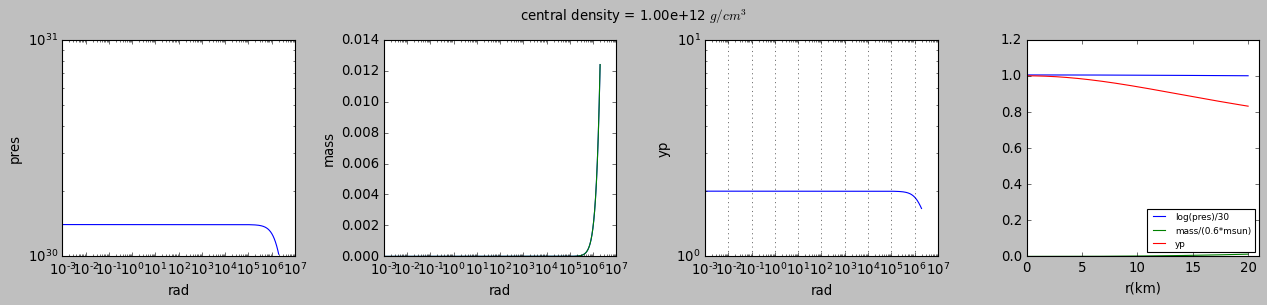

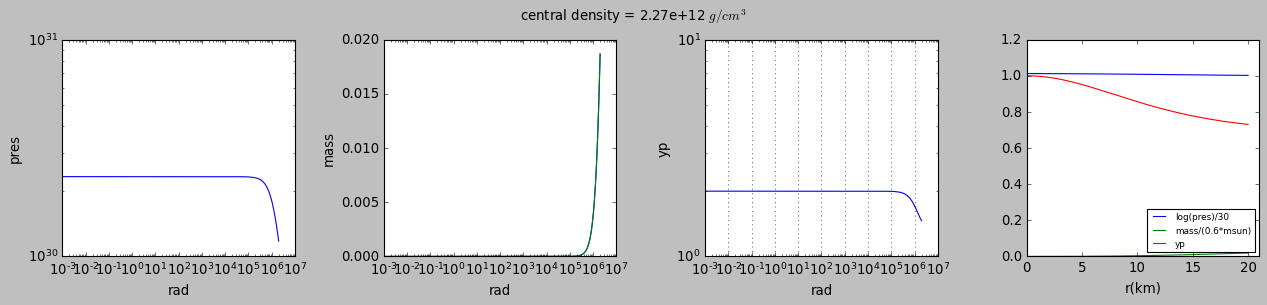

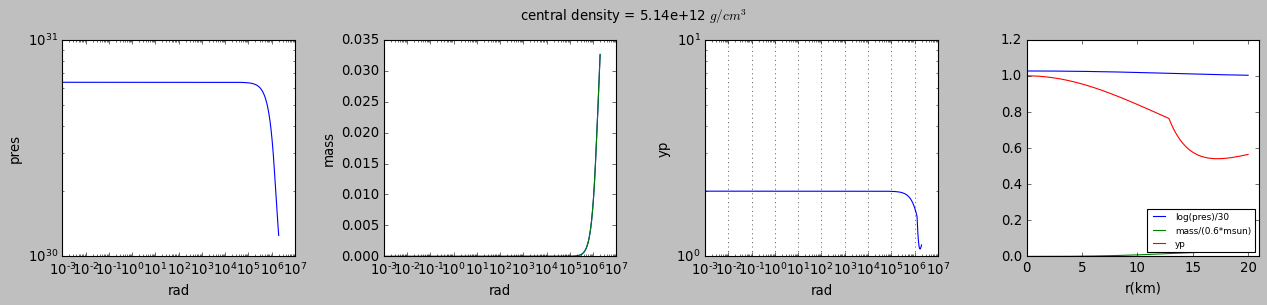

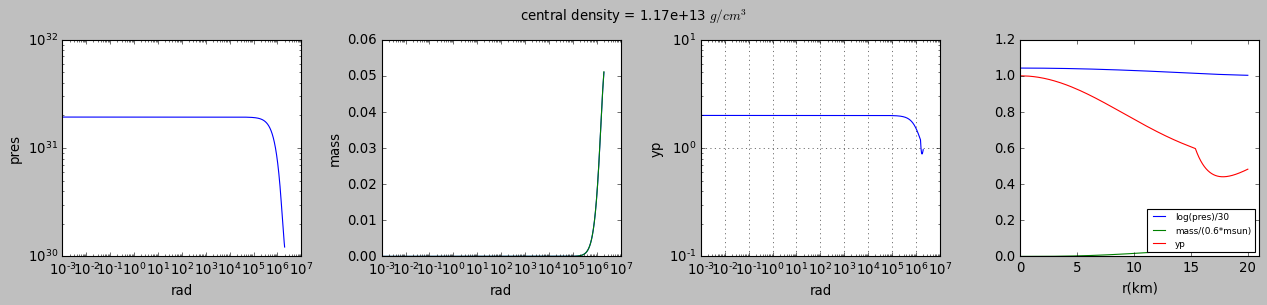

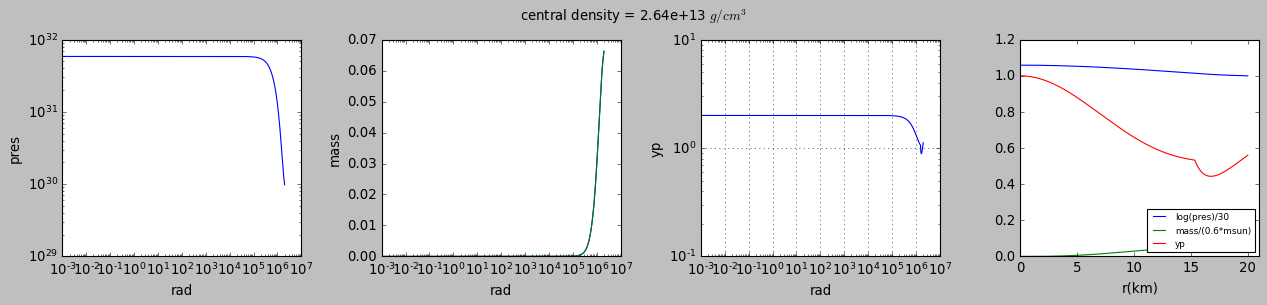

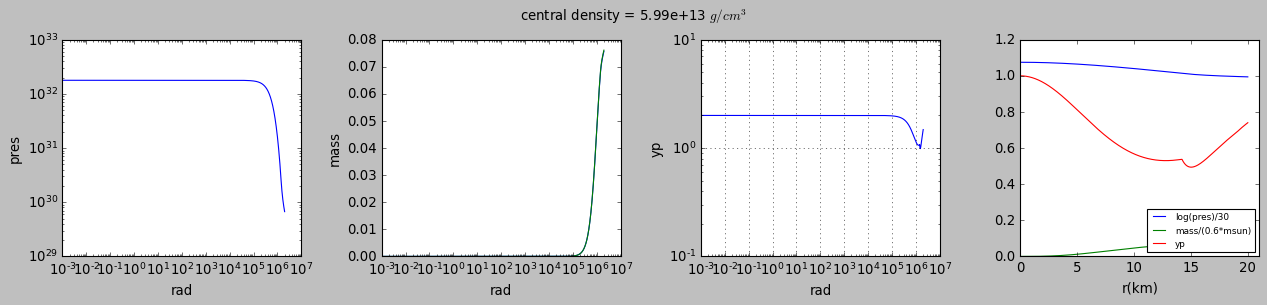

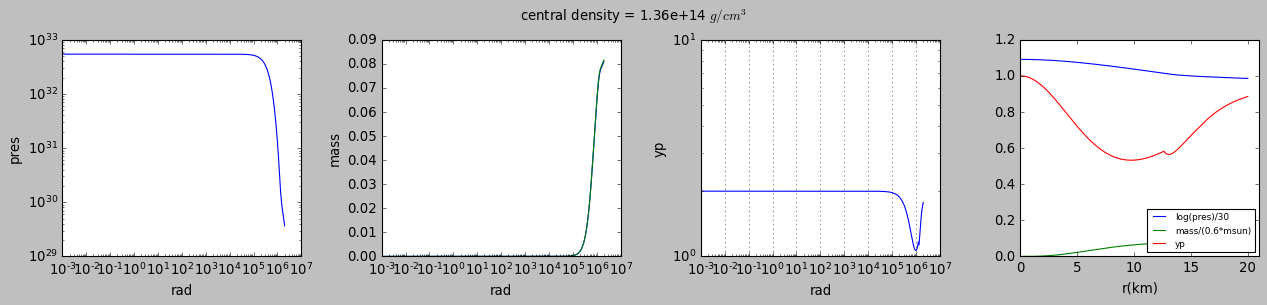

/home/rkashyap/sw/anaconda3/envs/gw_py377/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log10


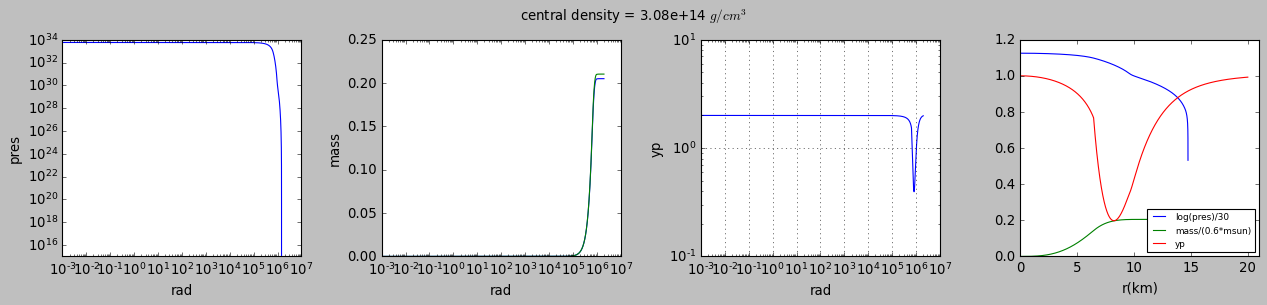

/home/rkashyap/sw/anaconda3/envs/gw_py377/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log10


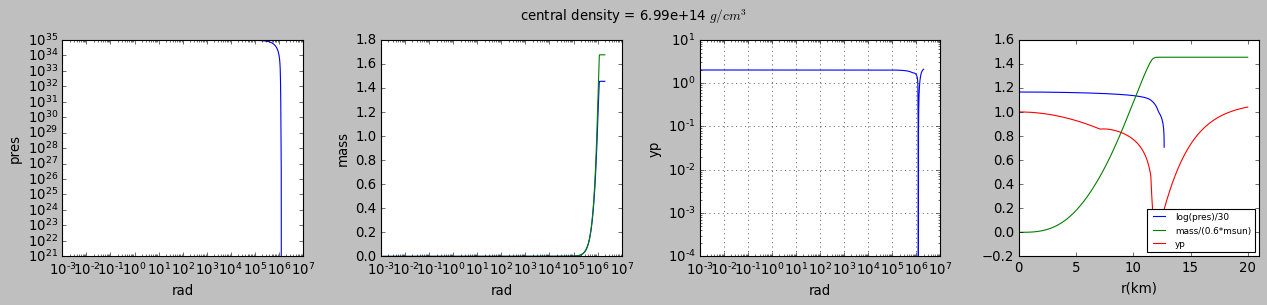

/home/rkashyap/sw/anaconda3/envs/gw_py377/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log10


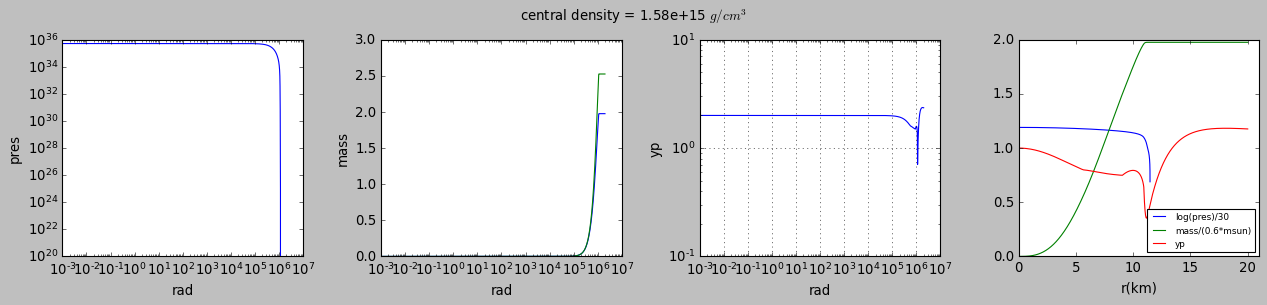

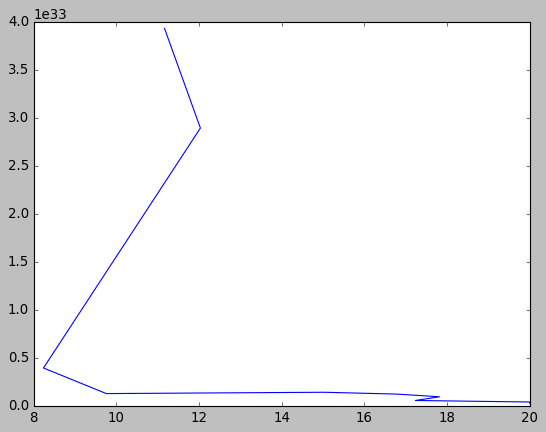

In [62]:
key='ALF2'
dense_eos = get_eos(key)
eos = glue_crust_and_core( SLyCrust, dense_eos )





int_pts = 10000
rad_low = 1.e-3
rad_high = 2.e6
N = 10
rhoc_arr = np.logspace(12.0, 15.2, N)
ALF2=tov(peos=eos,int_pts=int_pts,rad_low=rad_low,rad_high=rad_high,central_rho_arr=rhoc_arr)

rstar=[]
mstar=[]
lamstar=[]
for rhoc in rhoc_arr:
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(16,4))
    fig.suptitle(f'central density = {rhoc:1.2e} $g/cm^3$')
    rad, press, mass, mass_baryon, yp_lambda = ALF2.tovsolve(rhoc)
    
    ax1.plot(rad,press)
    ax1.set_xscale('log'); ax1.set_yscale('log')
    ax1.set(xlabel='rad',ylabel='pres')
    
    ax2.plot(rad,mass/const.CGS_MSUN)
    ax2.plot(rad,mass_baryon/const.CGS_MSUN)
    ax2.set(xlabel='rad',ylabel='mass')
    #ax2.set_xlim([9.e11,1.e16]) 
    ax2.set_xscale('log')#; ax2.set_yscale('log')
    
    ax3.plot(rad,yp_lambda)
    ax3.set(xlabel='rad',ylabel='yp')
    ax3.grid(True)
    #ax3.set_xlim([9.e11,1.e16]);ax3.set_ylim([0,1])
    ax3.set_xscale('log'); ax3.set_yscale('log')
    
    ax4.plot(rad/1.e5,np.log10(press)/30,label='log(pres)/30')
    ax4.plot(rad/1.e5,mass/const.CGS_MSUN,label='mass/(0.6*msun)')
    ax4.plot(rad/1.e5,yp_lambda/2,label='yp')
    #ax4.set_xscale('log'); ax4.set_yscale('log')
    ax4.set(xlabel='r(km)') #,ylabel='P')
    ax4.set_xlim([0,21])
    ax4.legend(loc=3,fontsize=8)
    plt.tight_layout()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    idx=np.argmin(yp_lambda)  #.index(min(yp_lambda))
    
    rstar.append(rad[idx])
    mstar.append(mass[idx])
    lamstar.append(yp_lambda[idx])

rstar=np.array(rstar); mstar=np.array(mstar)
plt.plot(rstar/1.e5,mstar)
plt.show()

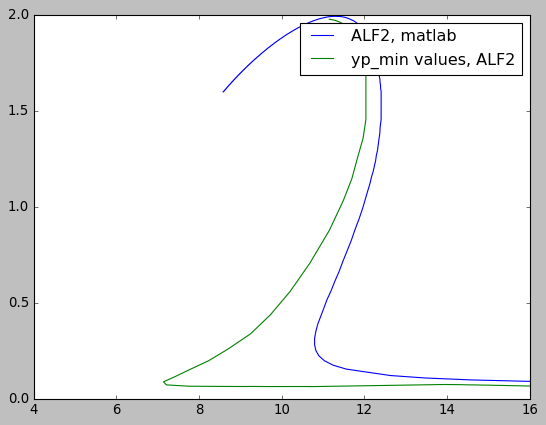

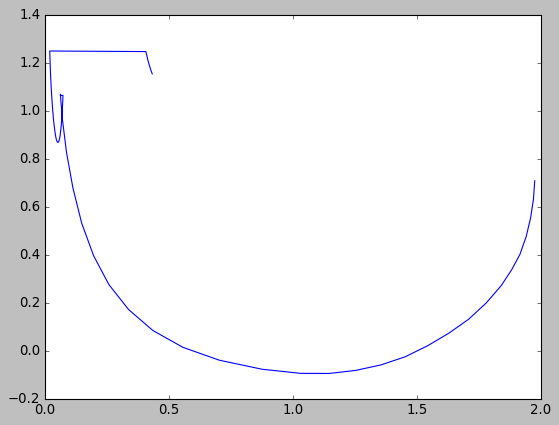

In [49]:
#print(rstar/1.e5)
#print(mstar/const.CGS_MSUN)
lamstar=np.array(lamstar)

file='./matlab_Sebastiano/tov/Sequences/Complete/ALF2_sequence.txt'
ds_matlab=np.loadtxt(file,skiprows=1)
plt.plot(ds_matlab[:,3]*const.AGEO_LENGTH_IN_M/1.e3,ds_matlab[:,1],label='ALF2, matlab')
plt.plot(rstar/1.e5,mstar/const.CGS_MSUN,label='yp_min values, ALF2')
plt.xlim([4,16])
plt.legend()
plt.show()

plt.plot(mstar/const.CGS_MSUN,lamstar)
plt.show()

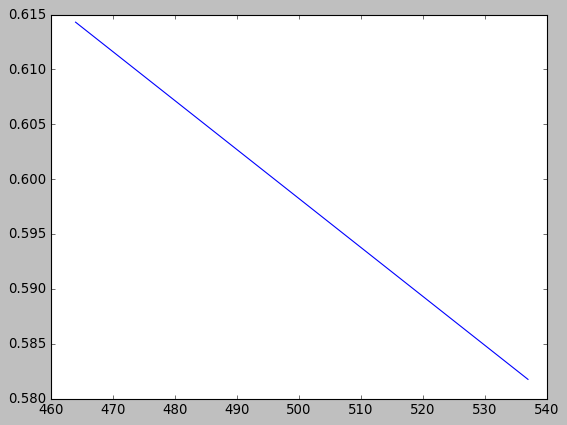

In [8]:
mstar,rstar,rhoc_star,mb_star,yp_star=ALF2.mass_radius()
#np.save('m_mB_rad_data/'+key,[mass,radius,rhoc,mb,yp])

plt.plot(rstar,mstar)
plt.show()